In [ ]:
import torch

from qubosolver.config import DeviceType, EmbeddingConfig, SolverConfig
from qubosolver.solver import QUBOInstance, QuboSolver


### Embedding worklow
This tutorial aims to show small code snippet on how to use the different embedding methods (`custom`, `greedy`) as well as how to parametrize the algorithms through the `SolverConfig` according to a given QUBO matrix.

In [ ]:
# import QUBO matrix manually
coefficients = torch.load("qubo_size_15.pt", weights_only=True)
instance = QUBOInstance(coefficients)

1. Define a `SolverConfig` to be passed to any solver

In [ ]:
config = SolverConfig(use_quantum=True)

For now, the `SolverConfig` contains parameters according to all available procedures (`pre-post processing`, `embedding`, `pulse shaping`). It has a default behavior that is compliant to the minimum requirements to run the workflow, as long as the given QUBO matrix fits with these default paremeters.

If one want to access to the default attributes, it is easily readable through the following:

In [ ]:
config.print_specs()

config_name: ''
use_quantum: True
backend_config: {'backend': <BackendType.QUTIP: 'qutip'>, 'username': None, 'password': None, 'project_id': None, 'device': None, 'dt': 10, 'wait': False}
n_calls: 20
embedding: {'embedding_method': <EmbedderType.GREEDY: 'greedy'>, 'layout_greedy_embedder': <LayoutType.TRIANGULAR: <class 'pulser.register.special_layouts.TriangularLatticeLayout'>>, 'steps_per_round_space_embedder': 150, 'starting_positions': None, 'dimensions': [2], 'traps': 1, 'spacing': 4.0, 'density': None, 'draw_steps': False, 'animation_save_path': None}
pulse_shaping: {'pulse_shaping_method': <PulseType.ADIABATIC: 'adiabatic'>, 'initial_omega_parameters': [5.0, 10.0, 5.0], 'initial_detuning_parameters': [-10.0, 0.0, 10.0], 're_execute_opt_pulse': False, 'custom_qubo_cost': None, 'custom_objective': None, 'callback_objective': None}
classical: {'classical_solver_type': 'cplex', 'cplex_maxtime': 600.0, 'cplex_log_path': 'solver.log'}
num_shots: 500
do_postprocessing: False
do_prepro

2) Define a `QuboSolver`, by passing the instance and the defined configuration

In [ ]:
solver = QuboSolver(instance, config)

3. Call the embedding method according to the provided set of parameters defined by the `SolverConfig`.

In [ ]:
geometry = solver.embedding()

From the chosen embedding method, we get a set of two-dimensional coordinates that should be embeddable on the register:

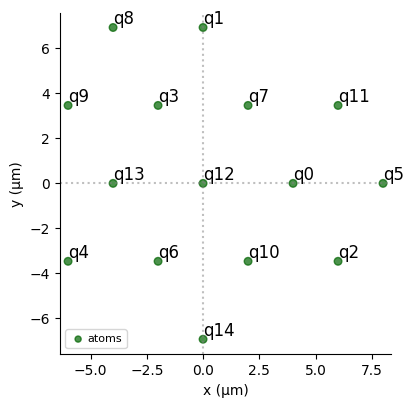

In [ ]:
geometry.register.draw()

### Greedy embedder parametrization
We do the same using the `greedy` embedding method, using a triangular lattice layout on a `DigitalAnalogDevice` with a number of traps at least equal to the number of variables in the QUBO:

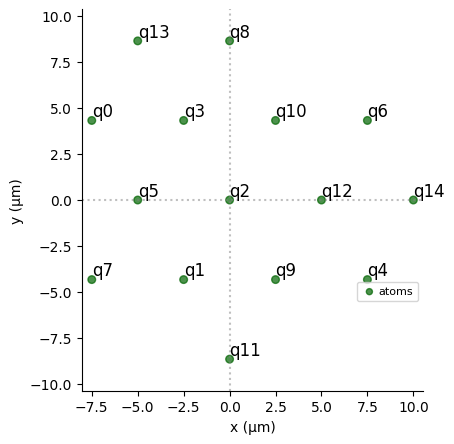

In [ ]:
greedy_settings = EmbeddingConfig(embedding_method="greedy", layout_greedy_embedder="triangular", traps=instance.size)

greedy_config = SolverConfig.from_kwargs(
    use_quantum=True,
    device=DeviceType.ANALOG_DEVICE,
    embedding=greedy_settings,
)

solver = QuboSolver(instance, greedy_config)
geometry = solver.embedding()
geometry.register.draw()

### Custom embedder

If one desires to develop his own embedding method, a subclass of `qubosolver.pipeline.embedder.BaseEmbedder` should be implemented with a mandatory `embed` method.

The `embed` method `def embed(self) -> qubosolver.pipeline.targets.Register` specify how the problem is mapped into a register of qubits when running using a quantum device. Let us show a simple example where each variable $i$ is mapped into a qubit lying on a horizontal line (with coordinates $[i, 0]$).

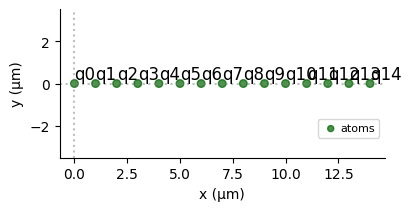

In [ ]:
import typing
from qubosolver.pipeline.embedder import BaseEmbedder
from qubosolver.pipeline.targets import Register as TargetRegister
from qubosolver.config import SolverConfig
from pulser.register import Register as PulserRegister

class FixedEmbedder(BaseEmbedder):

    @typing.no_type_check
    def embed(self) -> TargetRegister:
        qubits = {f"q{i}": (i,0) for i in range(self.instance.coefficients.shape[0])}
        register = PulserRegister(qubits)
        return TargetRegister(self.config.backend_config.device, register)


custom_config = SolverConfig.from_kwargs(
    use_quantum=True,
    embedding_method=FixedEmbedder,
)
solver = QuboSolver(instance, custom_config)
geometry = solver.embedding()
geometry.register.draw()

## Greedy algorithm - Vizualisation 

In [ ]:
from matplotlib import rc
rc("animation", html="jshtml")  # ensure inline animations

from importlib import reload


from qubosolver.solver import QUBOInstance, QuboSolver
from qubosolver.config import SolverConfig, EmbeddingConfig, BackendConfig
from qoolqit._solvers.types import DeviceType

 

In [ ]:
import torch

Q = torch.tensor([
    [-4.0, 1.0, 2.0, 1.5, 2.3, 0.9, 1.8, 2.7, 1.2],
    [ 1.0,-3.2, 1.7, 2.1, 0.8, 1.9, 2.2, 1.1, 1.6],
    [ 2.0, 1.7,-5.1, 0.7, 2.5, 1.3, 2.6, 1.4, 2.0],
    [ 1.5, 2.1, 0.7,-2.7, 1.2, 2.4, 0.6, 1.8, 2.1],
    [ 2.3, 0.8, 2.5, 1.2,-6.3, 1.0, 1.7, 2.8, 1.5],
    [ 0.9, 1.9, 1.3, 2.4, 1.0,-4.5, 2.3, 1.6, 0.9],
    [ 1.8, 2.2, 2.6, 0.6, 1.7, 2.3,-3.8, 1.2, 2.2],
    [ 2.7, 1.1, 1.4, 1.8, 2.8, 1.6, 1.2,-5.9, 1.4],
    [ 1.2, 1.6, 2.0, 2.1, 1.5, 0.9, 2.2, 1.4,-2.4],
], dtype=torch.float32)

instance = QUBOInstance(Q)

greedy_settings = EmbeddingConfig(
    embedding_method="greedy",
    layout_greedy_embedder="triangular",  # or "square"
    traps=instance.size + 6,
    spacing=5.0,
    draw_steps=True,                         # ← single toggle
    animation_save_path="greedy_demo.mp4",   # ← optional file export
)

backend = BackendConfig(device=DeviceType.ANALOG_DEVICE)

cfg = SolverConfig.from_kwargs(
    use_quantum=True,
    embedding=greedy_settings,
    device=backend.device,
)

solver = QuboSolver(instance, cfg)
geometry = solver.embedding()     # → inline animation + optional mp4


[anim] Save failed: ffmpeg is not available in PATH. Install ffmpeg or export GIF instead.
Animation.save using <class 'matplotlib.animation.HTMLWriter'>
